In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

## Data

In [2]:
# kaggle functions
def clean_text(txt):
    return re.sub('[^A-Za-z0-9]+', ' ', str(txt).lower()).strip()

In [3]:
train_df = pd.DataFrame(pd.read_csv('../resources/combined_data/train_with_text.csv'))\
     .drop(columns=['Unnamed: 0'])

test_df = pd.read_csv('../resources/combined_data/test_with_text.csv')\
                .drop(columns=['Unnamed: 0'])

train_df.head()

,Id,pub_title,dataset_title,dataset_label,cleaned_label,text
0,d0fa7568-7d8e-4db9-870f-f9c6f668c17b,The Impact of Dual Enrollment on College Degre...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,section title what is this study about text th...
1,2f26f645-3dec-485d-b68d-f013c9e05e60,Educational Attainment of High School Dropouts...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,section title november 2004 text dropping out ...
2,c5d5cd2c-59de-4f29-bbb1-6a88c7b52f29,Differences in Outcomes for Female and Male St...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,section title differences in outcomes for fema...
3,5c9a3bc9-41ba-4574-ad71-e25c1442c8af,Stepping Stone and Option Value in a Model of ...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,section title abstract text federal reserve ba...
4,c754dec7-c5a3-4337-9892-c02158475064,"Parental Effort, School Resources, and Student...",National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,section title abstract text this article inves...
...,...,...,...,...,...,...
19656,b3498176-8832-4033-aea6-b5ea85ea04c4,RSNA International Trends: A Global Perspectiv...,RSNA International COVID-19 Open Radiology Dat...,RSNA International COVID Open Radiology Database,rsna international covid open radiology database,section title introduction text our lives have...
19657,f77eb51f-c3ac-420b-9586-cb187849c321,MCCS: a novel recognition pattern-based method...,CAS COVID-19 antiviral candidate compounds dat...,CAS COVID-19 antiviral candidate compounds dat...,cas covid 19 antiviral candidate compounds dat...,section title introduction text the outbreak o...
19658,ab59bcdd-7b7c-4107-93f5-0ccaf749236c,Quantitative Structure–Activity Relationship M...,CAS COVID-19 antiviral candidate compounds dat...,CAS COVID-19 antiviral candidate compounds dat...,cas covid 19 antiviral candidate compounds dat...,section title introduction text the ongoing co...
19659,fd23e7e0-a5d2-4f98-992d-9209c85153bb,A ligand-based computational drug repurposing ...,CAS COVID-19 antiviral candidate compounds dat...,CAS COVID-19 antiviral candidate compounds dat...,cas covid 19 antiviral candidate compounds dat...,section title text deployment of approximative...


## Submission 1 (cheating)

In [4]:
# add all dataset labels in training set to list 
datasets_titles = train_df.cleaned_label.unique()

# check if in test text and add to submission dataframe 
labels = []
for index in test_df['Id']:
    text = test_df[test_df['Id'] == index].text.str.cat(sep='\n').lower()
    label = []
    for dataset_title in datasets_titles:
        if dataset_title in text:
            label.append(clean_text(dataset_title))
    labels.append('|'.join(label))

test_df['PredictionString'] = labels

submission_df = test_df.drop(columns=['text']).set_index('Id')

submission_df

,PredictionString
Id,
2100032a-7c33-4bff-97ef-690822c43466,adni|alzheimer s disease neuroimaging initiati...
2f392438-e215-4169-bebf-21ac4ff253e1,nces common core of data|trends in internation...
3f316b38-1a24-45a9-8d8c-4e05a42257c6,slosh model|noaa storm surge inundation
8e6996b4-ca08-4c0b-bed2-aaf07a4c6a60,rural urban continuum codes


In [ ]:
# submission_df.to_csv('../output/submission1.csv')

## ML approach

#### Feature engineering

In [6]:
X = train_df['text']
y = train_df['cleaned_label']

print(X.shape, y.shape)

(19661,) (19661,)


In [8]:
# split data
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize tfidf_vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7) 

# Fit and transform training data 
tfidf_train = tfidf_vectorizer.fit_transform(X_train) 

# Transform test set 
tfidf_test = tfidf_vectorizer.transform(X_test)

tfidf_df = pd.DataFrame(tfidf_train.A, columns=tfidf_vectorizer.get_feature_names())
tfidf_df

,00,000,0000,00000,000000,0000000,00000000,000000000,0000000000,000000000000,...,zzphu,zzstatistical,zzstefan,zzuk,zzvjph,zzwebsite,zzxi,zzxiai,zzy,zzz
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.002644,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.004538,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.002189,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14740,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14741,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14742,0.0,0.008064,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14743,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize CountVectorizer
count_vec = CountVectorizer(stop_words='english', max_df=0.7) 

# Fit and transform training data 
count_vec_train = count_vec.fit_transform(X_train) 

# Transform test set 
count_vec_test = count_vec.transform(X_test)

count_vec_df = pd.DataFrame(count_vec_train.A, columns=count_vec.get_feature_names())
count_vec_df

,00,000,0000,00000,000000,0000000,00000000,000000000,0000000000,000000000000,...,zzphu,zzstatistical,zzstefan,zzuk,zzvjph,zzwebsite,zzxi,zzxiai,zzy,zzz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14740,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14741,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14742,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14743,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Passive Aggressive Classifier
##### TF-IDF

In [11]:
from sklearn.linear_model import PassiveAggressiveClassifier 
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix 

# Create classifer and fit it to training data
clf = PassiveAggressiveClassifier(average=True,verbose=3)
clf.fit(tfidf_train, y_train)

score = clf.score(tfidf_test, y_test)
print("Passive Aggressive score:", score)

pred = clf.predict(tfidf_test)

print(confusion_matrix(y_test, pred))
print("Precision score: ",precision_score(y_test, pred, pos_label='positive', average='micro'))
print("Recall score:", recall_score(y_test, pred, pos_label='positive', average='micro'))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 1
Norm: 7.83, NNZs: 117651, Bias: -0.576638, T: 14745, Avg. loss: 0.004130
Total training time: 0.50 seconds.
-- Epoch 2
Norm: 7.98, NNZs: 118062, Bias: -0.577930, T: 29490, Avg. loss: 0.000161
Total training time: 0.61 seconds.
-- Epoch 3
Norm: 8.11, NNZs: 118269, Bias: -0.575515, T: 44235, Avg. loss: 0.000076
Total training time: 0.73 seconds.
-- Epoch 4
Norm: 8.16, NNZs: 118269, Bias: -0.576094, T: 58980, Avg. loss: 0.000035
Total training time: 0.85 seconds.
-- Epoch 5
Norm: 8.18, NNZs: 118469, Bias: -0.577292, T: 73725, Avg. loss: 0.000017
Total training time: 0.96 seconds.
-- Epoch 6
Norm: 8.19, NNZs: 118469, Bias: -0.577248, T: 88470, Avg. loss: 0.000002
Total training time: 1.07 seconds.
-- Epoch 7
Norm: 8.19, NNZs: 118469, Bias: -0.577195, T: 103215, Avg. loss: 0.000000
Total training time: 1.20 seconds.
Convergence after 7 epochs took 1.21 seconds
-- Epoch 1
Norm: 7.85, NNZs: 132158, Bias: -0.571305, T: 14745, Avg. loss: 0.004779
Total training time: 0.13 seconds.
--

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


Norm: 8.43, NNZs: 134332, Bias: -0.594681, T: 29490, Avg. loss: 0.000790
Total training time: 0.25 seconds.
-- Epoch 3
Norm: 8.97, NNZs: 135297, Bias: -0.601871, T: 44235, Avg. loss: 0.000536
Total training time: 0.37 seconds.
-- Epoch 4
Norm: 9.28, NNZs: 135878, Bias: -0.613843, T: 58980, Avg. loss: 0.000316
Total training time: 0.51 seconds.
-- Epoch 5
Norm: 9.49, NNZs: 135938, Bias: -0.613836, T: 73725, Avg. loss: 0.000170
Total training time: 0.62 seconds.
-- Epoch 6
Norm: 9.62, NNZs: 136061, Bias: -0.617880, T: 88470, Avg. loss: 0.000111
Total training time: 0.75 seconds.
-- Epoch 7
Norm: 9.72, NNZs: 136282, Bias: -0.617044, T: 103215, Avg. loss: 0.000065
Total training time: 0.88 seconds.
Convergence after 7 epochs took 0.88 seconds
-- Epoch 1


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.1s remaining:    0.0s


Norm: 7.90, NNZs: 119151, Bias: -0.576789, T: 14745, Avg. loss: 0.004760
Total training time: 0.16 seconds.
-- Epoch 2
Norm: 8.10, NNZs: 119686, Bias: -0.585593, T: 29490, Avg. loss: 0.000822
Total training time: 0.28 seconds.
-- Epoch 3
Norm: 8.33, NNZs: 120301, Bias: -0.581918, T: 44235, Avg. loss: 0.000718
Total training time: 0.39 seconds.
-- Epoch 4
Norm: 8.54, NNZs: 120555, Bias: -0.584015, T: 58980, Avg. loss: 0.000668
Total training time: 0.52 seconds.
-- Epoch 5
Norm: 8.72, NNZs: 120702, Bias: -0.603264, T: 73725, Avg. loss: 0.000602
Total training time: 0.66 seconds.
-- Epoch 6
Norm: 8.81, NNZs: 120702, Bias: -0.595634, T: 88470, Avg. loss: 0.000582
Total training time: 0.79 seconds.
-- Epoch 7
Norm: 9.01, NNZs: 120961, Bias: -0.611251, T: 103215, Avg. loss: 0.000630
Total training time: 0.91 seconds.
Convergence after 7 epochs took 0.91 seconds
-- Epoch 1
Norm: 36.96, NNZs: 218535, Bias: -0.336390, T: 14745, Avg. loss: 0.384954
Total training time: 0.12 seconds.
-- Epoch 2
N

Norm: 41.19, NNZs: 159058, Bias: -0.862601, T: 162195, Avg. loss: 0.012209
Total training time: 1.22 seconds.
Convergence after 11 epochs took 1.22 seconds
-- Epoch 1
Norm: 8.32, NNZs: 125853, Bias: -0.582888, T: 14745, Avg. loss: 0.007371
Total training time: 0.11 seconds.
-- Epoch 2
Norm: 9.43, NNZs: 129486, Bias: -0.596479, T: 29490, Avg. loss: 0.003051
Total training time: 0.22 seconds.
-- Epoch 3
Norm: 10.56, NNZs: 130547, Bias: -0.604393, T: 44235, Avg. loss: 0.002514
Total training time: 0.33 seconds.
-- Epoch 4
Norm: 11.30, NNZs: 131493, Bias: -0.618498, T: 58980, Avg. loss: 0.002055
Total training time: 0.44 seconds.
-- Epoch 5
Norm: 11.92, NNZs: 131811, Bias: -0.621769, T: 73725, Avg. loss: 0.001784
Total training time: 0.55 seconds.
-- Epoch 6
Norm: 12.47, NNZs: 132412, Bias: -0.632980, T: 88470, Avg. loss: 0.001686
Total training time: 0.67 seconds.
-- Epoch 7
Norm: 12.86, NNZs: 132579, Bias: -0.629217, T: 103215, Avg. loss: 0.001353
Total training time: 0.82 seconds.
Conve

Norm: 18.08, NNZs: 143744, Bias: -0.861892, T: 44235, Avg. loss: 0.023202
Total training time: 0.34 seconds.
-- Epoch 4
Norm: 20.14, NNZs: 145256, Bias: -0.901037, T: 58980, Avg. loss: 0.021403
Total training time: 0.45 seconds.
-- Epoch 5
Norm: 22.09, NNZs: 146499, Bias: -0.928648, T: 73725, Avg. loss: 0.020815
Total training time: 0.56 seconds.
-- Epoch 6
Norm: 23.66, NNZs: 147113, Bias: -0.979327, T: 88470, Avg. loss: 0.019470
Total training time: 0.67 seconds.
-- Epoch 7
Norm: 25.17, NNZs: 148117, Bias: -0.990105, T: 103215, Avg. loss: 0.019458
Total training time: 0.77 seconds.
-- Epoch 8
Norm: 26.38, NNZs: 148225, Bias: -1.005077, T: 117960, Avg. loss: 0.019545
Total training time: 0.88 seconds.
-- Epoch 9
Norm: 27.51, NNZs: 148459, Bias: -1.026997, T: 132705, Avg. loss: 0.018951
Total training time: 0.99 seconds.
-- Epoch 10
Norm: 28.30, NNZs: 148763, Bias: -1.039823, T: 147450, Avg. loss: 0.018639
Total training time: 1.09 seconds.
-- Epoch 11
Norm: 29.15, NNZs: 149130, Bias: -

Norm: 16.42, NNZs: 164748, Bias: -0.882198, T: 73725, Avg. loss: 0.021374
Total training time: 0.56 seconds.
-- Epoch 6
Norm: 17.52, NNZs: 165045, Bias: -0.912203, T: 88470, Avg. loss: 0.021551
Total training time: 0.67 seconds.
-- Epoch 7
Norm: 18.75, NNZs: 170671, Bias: -0.922895, T: 103215, Avg. loss: 0.020872
Total training time: 0.78 seconds.
-- Epoch 8
Norm: 19.35, NNZs: 171087, Bias: -0.955142, T: 117960, Avg. loss: 0.021209
Total training time: 0.90 seconds.
-- Epoch 9
Norm: 19.97, NNZs: 171136, Bias: -0.973792, T: 132705, Avg. loss: 0.021224
Total training time: 1.01 seconds.
Convergence after 9 epochs took 1.01 seconds
-- Epoch 1
Norm: 7.85, NNZs: 116999, Bias: -0.574569, T: 14745, Avg. loss: 0.004121
Total training time: 0.11 seconds.
-- Epoch 2
Norm: 7.97, NNZs: 117716, Bias: -0.568984, T: 29490, Avg. loss: 0.000120
Total training time: 0.22 seconds.
-- Epoch 3
Norm: 8.04, NNZs: 117964, Bias: -0.568416, T: 44235, Avg. loss: 0.000042
Total training time: 0.33 seconds.
-- Epo

Norm: 8.31, NNZs: 125832, Bias: -0.587361, T: 73725, Avg. loss: 0.001030
Total training time: 0.56 seconds.
-- Epoch 6
Norm: 8.37, NNZs: 126317, Bias: -0.587860, T: 88470, Avg. loss: 0.001016
Total training time: 0.67 seconds.
-- Epoch 7
Norm: 8.45, NNZs: 126518, Bias: -0.593192, T: 103215, Avg. loss: 0.001042
Total training time: 0.78 seconds.
Convergence after 7 epochs took 0.78 seconds
-- Epoch 1
Norm: 13.74, NNZs: 121957, Bias: -0.717101, T: 14745, Avg. loss: 0.038364
Total training time: 0.11 seconds.
-- Epoch 2
Norm: 18.85, NNZs: 164021, Bias: -0.745060, T: 29490, Avg. loss: 0.026743
Total training time: 0.22 seconds.
-- Epoch 3
Norm: 22.36, NNZs: 167473, Bias: -0.840488, T: 44235, Avg. loss: 0.022812
Total training time: 0.33 seconds.
-- Epoch 4
Norm: 24.77, NNZs: 168695, Bias: -0.868564, T: 58980, Avg. loss: 0.020879
Total training time: 0.44 seconds.
-- Epoch 5
Norm: 27.02, NNZs: 169774, Bias: -0.919932, T: 73725, Avg. loss: 0.018955
Total training time: 0.55 seconds.
-- Epoch

Norm: 9.67, NNZs: 127776, Bias: -0.583816, T: 103215, Avg. loss: 0.000055
Total training time: 0.85 seconds.
Convergence after 7 epochs took 0.85 seconds
-- Epoch 1
Norm: 11.63, NNZs: 101658, Bias: -0.597182, T: 14745, Avg. loss: 0.018788
Total training time: 0.12 seconds.
-- Epoch 2
Norm: 14.76, NNZs: 106412, Bias: -0.608054, T: 29490, Avg. loss: 0.010601
Total training time: 0.23 seconds.
-- Epoch 3
Norm: 16.61, NNZs: 109340, Bias: -0.716772, T: 44235, Avg. loss: 0.008146
Total training time: 0.34 seconds.
-- Epoch 4
Norm: 18.58, NNZs: 110463, Bias: -0.666622, T: 58980, Avg. loss: 0.007606
Total training time: 0.45 seconds.
-- Epoch 5
Norm: 19.33, NNZs: 110958, Bias: -0.735741, T: 73725, Avg. loss: 0.006977
Total training time: 0.62 seconds.
-- Epoch 6
Norm: 20.09, NNZs: 111241, Bias: -0.708993, T: 88470, Avg. loss: 0.006728
Total training time: 0.74 seconds.
-- Epoch 7
Norm: 20.56, NNZs: 111371, Bias: -0.726884, T: 103215, Avg. loss: 0.006499
Total training time: 0.85 seconds.
-- Ep

Norm: 10.87, NNZs: 124366, Bias: -0.620845, T: 58980, Avg. loss: 0.000845
Total training time: 0.53 seconds.
-- Epoch 5
Norm: 11.37, NNZs: 124366, Bias: -0.619207, T: 73725, Avg. loss: 0.000650
Total training time: 0.71 seconds.
-- Epoch 6
Norm: 11.63, NNZs: 124649, Bias: -0.618928, T: 88470, Avg. loss: 0.000434
Total training time: 0.83 seconds.
-- Epoch 7
Norm: 11.88, NNZs: 124738, Bias: -0.623816, T: 103215, Avg. loss: 0.000424
Total training time: 0.97 seconds.
Convergence after 7 epochs took 0.97 seconds
-- Epoch 1
Norm: 8.02, NNZs: 128797, Bias: -0.582599, T: 14745, Avg. loss: 0.005039
Total training time: 0.16 seconds.
-- Epoch 2
Norm: 8.51, NNZs: 130189, Bias: -0.584579, T: 29490, Avg. loss: 0.000879
Total training time: 0.27 seconds.
-- Epoch 3
Norm: 9.12, NNZs: 130838, Bias: -0.592662, T: 44235, Avg. loss: 0.000656
Total training time: 0.38 seconds.
-- Epoch 4
Norm: 9.48, NNZs: 131260, Bias: -0.594745, T: 58980, Avg. loss: 0.000405
Total training time: 0.51 seconds.
-- Epoch 

Norm: 10.72, NNZs: 133784, Bias: -0.652786, T: 103215, Avg. loss: 0.001697
Total training time: 0.80 seconds.
Convergence after 7 epochs took 0.80 seconds
-- Epoch 1
Norm: 14.09, NNZs: 173562, Bias: -0.670585, T: 14745, Avg. loss: 0.029988
Total training time: 0.13 seconds.
-- Epoch 2
Norm: 17.23, NNZs: 178128, Bias: -0.667022, T: 29490, Avg. loss: 0.018120
Total training time: 0.26 seconds.
-- Epoch 3
Norm: 19.66, NNZs: 180667, Bias: -0.695049, T: 44235, Avg. loss: 0.015417
Total training time: 0.39 seconds.
-- Epoch 4
Norm: 21.46, NNZs: 182462, Bias: -0.709181, T: 58980, Avg. loss: 0.014404
Total training time: 0.50 seconds.
-- Epoch 5
Norm: 23.09, NNZs: 183311, Bias: -0.734344, T: 73725, Avg. loss: 0.013476
Total training time: 0.62 seconds.
-- Epoch 6
Norm: 24.29, NNZs: 184391, Bias: -0.737307, T: 88470, Avg. loss: 0.013317
Total training time: 0.75 seconds.
-- Epoch 7
Norm: 25.53, NNZs: 184688, Bias: -0.737209, T: 103215, Avg. loss: 0.012747
Total training time: 0.90 seconds.
-- E

Norm: 7.96, NNZs: 117555, Bias: -0.584371, T: 73725, Avg. loss: 0.000201
Total training time: 0.63 seconds.
-- Epoch 6
Norm: 7.97, NNZs: 117555, Bias: -0.583483, T: 88470, Avg. loss: 0.000198
Total training time: 0.75 seconds.
-- Epoch 7
Norm: 8.02, NNZs: 117586, Bias: -0.589950, T: 103215, Avg. loss: 0.000232
Total training time: 0.86 seconds.
Convergence after 7 epochs took 0.86 seconds
-- Epoch 1
Norm: 7.59, NNZs: 120262, Bias: -0.581757, T: 14745, Avg. loss: 0.004304
Total training time: 0.13 seconds.
-- Epoch 2
Norm: 7.54, NNZs: 121950, Bias: -0.594776, T: 29490, Avg. loss: 0.000383
Total training time: 0.27 seconds.
-- Epoch 3
Norm: 7.55, NNZs: 125285, Bias: -0.605496, T: 44235, Avg. loss: 0.000327
Total training time: 0.41 seconds.
-- Epoch 4
Norm: 7.56, NNZs: 125471, Bias: -0.608295, T: 58980, Avg. loss: 0.000244
Total training time: 0.56 seconds.
-- Epoch 5
Norm: 7.61, NNZs: 126927, Bias: -0.613742, T: 73725, Avg. loss: 0.000248
Total training time: 0.70 seconds.
-- Epoch 6
No

Norm: 7.70, NNZs: 127784, Bias: -0.614152, T: 58980, Avg. loss: 0.000466
Total training time: 0.49 seconds.
-- Epoch 5
Norm: 7.76, NNZs: 129297, Bias: -0.622417, T: 73725, Avg. loss: 0.000480
Total training time: 0.62 seconds.
-- Epoch 6
Norm: 7.80, NNZs: 130307, Bias: -0.623372, T: 88470, Avg. loss: 0.000425
Total training time: 0.76 seconds.
-- Epoch 7
Norm: 7.92, NNZs: 130958, Bias: -0.642643, T: 103215, Avg. loss: 0.000538
Total training time: 0.89 seconds.
Convergence after 7 epochs took 0.89 seconds
-- Epoch 1
Norm: 7.71, NNZs: 121322, Bias: -0.586299, T: 14745, Avg. loss: 0.005417
Total training time: 0.14 seconds.
-- Epoch 2
Norm: 8.01, NNZs: 122825, Bias: -0.610465, T: 29490, Avg. loss: 0.001407
Total training time: 0.27 seconds.
-- Epoch 3
Norm: 8.37, NNZs: 124200, Bias: -0.620780, T: 44235, Avg. loss: 0.001262
Total training time: 0.39 seconds.
-- Epoch 4
Norm: 8.71, NNZs: 124737, Bias: -0.642522, T: 58980, Avg. loss: 0.001273
Total training time: 0.49 seconds.
-- Epoch 5
No

Norm: 15.99, NNZs: 142004, Bias: -0.710493, T: 88470, Avg. loss: 0.006894
Total training time: 0.66 seconds.
-- Epoch 7
Norm: 16.80, NNZs: 142329, Bias: -0.710057, T: 103215, Avg. loss: 0.006669
Total training time: 0.77 seconds.
Convergence after 7 epochs took 0.77 seconds
-- Epoch 1
Norm: 7.87, NNZs: 117325, Bias: -0.583804, T: 14745, Avg. loss: 0.004189
Total training time: 0.12 seconds.
-- Epoch 2
Norm: 7.88, NNZs: 117482, Bias: -0.584272, T: 29490, Avg. loss: 0.000208
Total training time: 0.23 seconds.
-- Epoch 3
Norm: 7.89, NNZs: 117537, Bias: -0.575950, T: 44235, Avg. loss: 0.000148
Total training time: 0.34 seconds.
-- Epoch 4
Norm: 7.90, NNZs: 117537, Bias: -0.575853, T: 58980, Avg. loss: 0.000203
Total training time: 0.45 seconds.
-- Epoch 5
Norm: 7.91, NNZs: 117556, Bias: -0.577559, T: 73725, Avg. loss: 0.000214
Total training time: 0.58 seconds.
-- Epoch 6
Norm: 7.91, NNZs: 117613, Bias: -0.577652, T: 88470, Avg. loss: 0.000205
Total training time: 0.71 seconds.
-- Epoch 7


Norm: 13.34, NNZs: 141882, Bias: -0.617524, T: 103215, Avg. loss: 0.000744
Total training time: 0.81 seconds.
-- Epoch 8
Norm: 13.42, NNZs: 141903, Bias: -0.615803, T: 117960, Avg. loss: 0.000670
Total training time: 0.93 seconds.
Convergence after 8 epochs took 0.93 seconds
-- Epoch 1
Norm: 16.43, NNZs: 193879, Bias: -0.612455, T: 14745, Avg. loss: 0.036208
Total training time: 0.14 seconds.
-- Epoch 2
Norm: 22.35, NNZs: 206870, Bias: -0.648419, T: 29490, Avg. loss: 0.019206
Total training time: 0.28 seconds.
-- Epoch 3
Norm: 25.58, NNZs: 208544, Bias: -0.676103, T: 44235, Avg. loss: 0.012057
Total training time: 0.43 seconds.
-- Epoch 4
Norm: 27.98, NNZs: 210432, Bias: -0.696404, T: 58980, Avg. loss: 0.009502
Total training time: 0.72 seconds.
-- Epoch 5
Norm: 29.63, NNZs: 211646, Bias: -0.717896, T: 73725, Avg. loss: 0.007590
Total training time: 0.92 seconds.
-- Epoch 6
Norm: 30.89, NNZs: 211863, Bias: -0.697075, T: 88470, Avg. loss: 0.005857
Total training time: 1.08 seconds.
-- E

Norm: 8.76, NNZs: 133220, Bias: -0.640106, T: 14745, Avg. loss: 0.013431
Total training time: 0.12 seconds.
-- Epoch 2
Norm: 9.48, NNZs: 135401, Bias: -0.643501, T: 29490, Avg. loss: 0.008522
Total training time: 0.24 seconds.
-- Epoch 3
Norm: 10.97, NNZs: 137176, Bias: -0.670024, T: 44235, Avg. loss: 0.008399
Total training time: 0.37 seconds.
-- Epoch 4
Norm: 11.99, NNZs: 138240, Bias: -0.750561, T: 58980, Avg. loss: 0.007884
Total training time: 0.49 seconds.
-- Epoch 5
Norm: 12.65, NNZs: 141026, Bias: -0.737163, T: 73725, Avg. loss: 0.007474
Total training time: 0.60 seconds.
-- Epoch 6
Norm: 13.21, NNZs: 141339, Bias: -0.768622, T: 88470, Avg. loss: 0.007699
Total training time: 0.74 seconds.
-- Epoch 7
Norm: 14.21, NNZs: 142300, Bias: -0.775701, T: 103215, Avg. loss: 0.007455
Total training time: 0.88 seconds.
Convergence after 7 epochs took 0.88 seconds
-- Epoch 1
Norm: 7.66, NNZs: 132899, Bias: -0.588636, T: 14745, Avg. loss: 0.005712
Total training time: 0.13 seconds.
-- Epoch

Norm: 14.81, NNZs: 142170, Bias: -0.659311, T: 73725, Avg. loss: 0.000871
Total training time: 0.68 seconds.
-- Epoch 6
Norm: 14.96, NNZs: 142219, Bias: -0.668514, T: 88470, Avg. loss: 0.000616
Total training time: 0.82 seconds.
-- Epoch 7
Norm: 15.42, NNZs: 142501, Bias: -0.664241, T: 103215, Avg. loss: 0.000866
Total training time: 0.95 seconds.
-- Epoch 8
Norm: 15.57, NNZs: 142637, Bias: -0.667742, T: 117960, Avg. loss: 0.000603
Total training time: 1.07 seconds.
Convergence after 8 epochs took 1.07 seconds
-- Epoch 1
Norm: 7.77, NNZs: 116696, Bias: -0.573818, T: 14745, Avg. loss: 0.004143
Total training time: 0.15 seconds.
-- Epoch 2
Norm: 7.81, NNZs: 117061, Bias: -0.570453, T: 29490, Avg. loss: 0.000181
Total training time: 0.28 seconds.
-- Epoch 3
Norm: 7.83, NNZs: 117183, Bias: -0.573443, T: 44235, Avg. loss: 0.000224
Total training time: 0.41 seconds.
-- Epoch 4
Norm: 7.84, NNZs: 117183, Bias: -0.572419, T: 58980, Avg. loss: 0.000197
Total training time: 0.52 seconds.
-- Epoch

Norm: 22.37, NNZs: 118169, Bias: -0.688806, T: 58980, Avg. loss: 0.011364
Total training time: 0.51 seconds.
-- Epoch 5
Norm: 24.22, NNZs: 119287, Bias: -0.720761, T: 73725, Avg. loss: 0.009787
Total training time: 0.64 seconds.
-- Epoch 6
Norm: 26.05, NNZs: 119665, Bias: -0.747035, T: 88470, Avg. loss: 0.009347
Total training time: 0.77 seconds.
-- Epoch 7
Norm: 27.59, NNZs: 119728, Bias: -0.773221, T: 103215, Avg. loss: 0.008275
Total training time: 0.88 seconds.
-- Epoch 8
Norm: 28.83, NNZs: 120042, Bias: -0.769641, T: 117960, Avg. loss: 0.007774
Total training time: 0.99 seconds.
-- Epoch 9
Norm: 29.81, NNZs: 120060, Bias: -0.805163, T: 132705, Avg. loss: 0.007137
Total training time: 1.12 seconds.
-- Epoch 10
Norm: 31.01, NNZs: 120245, Bias: -0.809638, T: 147450, Avg. loss: 0.007380
Total training time: 1.25 seconds.
-- Epoch 11
Norm: 31.82, NNZs: 120253, Bias: -0.797772, T: 162195, Avg. loss: 0.006882
Total training time: 1.38 seconds.
-- Epoch 12
Norm: 32.51, NNZs: 120260, Bias:

Norm: 13.06, NNZs: 146816, Bias: -0.709747, T: 44235, Avg. loss: 0.007059
Total training time: 0.34 seconds.
-- Epoch 4
Norm: 14.08, NNZs: 148026, Bias: -0.746206, T: 58980, Avg. loss: 0.006412
Total training time: 0.45 seconds.
-- Epoch 5
Norm: 14.85, NNZs: 148528, Bias: -0.760891, T: 73725, Avg. loss: 0.005709
Total training time: 0.57 seconds.
-- Epoch 6
Norm: 15.53, NNZs: 149277, Bias: -0.779969, T: 88470, Avg. loss: 0.005923
Total training time: 0.69 seconds.
-- Epoch 7
Norm: 16.12, NNZs: 150094, Bias: -0.772718, T: 103215, Avg. loss: 0.005649
Total training time: 0.82 seconds.
-- Epoch 8
Norm: 16.66, NNZs: 150709, Bias: -0.812385, T: 117960, Avg. loss: 0.005804
Total training time: 0.95 seconds.
Convergence after 8 epochs took 0.95 seconds
-- Epoch 1
Norm: 11.73, NNZs: 109153, Bias: -0.648500, T: 14745, Avg. loss: 0.014054
Total training time: 0.12 seconds.
-- Epoch 2
Norm: 13.51, NNZs: 111286, Bias: -0.656484, T: 29490, Avg. loss: 0.005047
Total training time: 0.24 seconds.
-- E

Norm: 8.08, NNZs: 125435, Bias: -0.585573, T: 44235, Avg. loss: 0.000893
Total training time: 0.40 seconds.
-- Epoch 4
Norm: 8.27, NNZs: 126588, Bias: -0.611233, T: 58980, Avg. loss: 0.001122
Total training time: 0.54 seconds.
-- Epoch 5
Norm: 8.27, NNZs: 126588, Bias: -0.608555, T: 73725, Avg. loss: 0.001009
Total training time: 0.68 seconds.
-- Epoch 6
Norm: 8.35, NNZs: 127024, Bias: -0.617335, T: 88470, Avg. loss: 0.001060
Total training time: 0.81 seconds.
-- Epoch 7
Norm: 8.39, NNZs: 127024, Bias: -0.600760, T: 103215, Avg. loss: 0.000909
Total training time: 0.95 seconds.
Convergence after 7 epochs took 0.95 seconds
-- Epoch 1
Norm: 17.41, NNZs: 154092, Bias: -0.617424, T: 14745, Avg. loss: 0.027683
Total training time: 0.13 seconds.
-- Epoch 2
Norm: 20.67, NNZs: 161772, Bias: -0.620063, T: 29490, Avg. loss: 0.010283
Total training time: 0.24 seconds.
-- Epoch 3
Norm: 22.49, NNZs: 162517, Bias: -0.615812, T: 44235, Avg. loss: 0.006502
Total training time: 0.38 seconds.
-- Epoch 4

[Parallel(n_jobs=1)]: Done 127 out of 127 | elapsed:  2.2min finished


Passive Aggressive score: 0.41863303498779497
[[  0   0   0 ...   0   0   0]
 [  0 355   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   2   0 ...   0   0  71]]
Precision score:  0.41863303498779497
Recall score: 0.41863303498779497


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1298: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1298: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


#### Passive Aggressive Classifier
##### Count vec

In [12]:
from sklearn.linear_model import PassiveAggressiveClassifier 
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix 

clf = PassiveAggressiveClassifier(average=True,verbose=3)
clf.fit(count_vec_train, y_train)

score = clf.score(count_vec_test, y_test)
print("Passive Aggressive score:", score)

pred = clf.predict(count_vec_test)

print(confusion_matrix(y_test, pred))
print("Precision score: ",precision_score(y_test, pred, pos_label='positive', average='micro'))
print("Recall score:", recall_score(y_test, pred, pos_label='positive', average='micro'))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 1
Norm: 0.34, NNZs: 14723, Bias: -0.000824, T: 14745, Avg. loss: 0.003442
Total training time: 0.14 seconds.
-- Epoch 2
Norm: 0.34, NNZs: 14723, Bias: -0.000818, T: 29490, Avg. loss: 0.000080
Total training time: 0.26 seconds.
-- Epoch 3
Norm: 0.34, NNZs: 14723, Bias: -0.000823, T: 44235, Avg. loss: 0.000045
Total training time: 0.38 seconds.
-- Epoch 4
Norm: 0.34, NNZs: 14723, Bias: -0.000824, T: 58980, Avg. loss: 0.000004
Total training time: 0.50 seconds.
-- Epoch 5
Norm: 0.34, NNZs: 14723, Bias: -0.000824, T: 73725, Avg. loss: 0.000002
Total training time: 0.63 seconds.
-- Epoch 6
Norm: 0.34, NNZs: 14723, Bias: -0.000824, T: 88470, Avg. loss: 0.000000
Total training time: 0.76 seconds.
-- Epoch 7
Norm: 0.34, NNZs: 14723, Bias: -0.000824, T: 103215, Avg. loss: 0.000000
Total training time: 0.92 seconds.
Convergence after 7 epochs took 0.92 seconds
-- Epoch 1


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


Norm: 0.34, NNZs: 15665, Bias: -0.000849, T: 14745, Avg. loss: 0.004738
Total training time: 0.17 seconds.
-- Epoch 2
Norm: 0.34, NNZs: 16294, Bias: -0.000850, T: 29490, Avg. loss: 0.000799
Total training time: 0.29 seconds.
-- Epoch 3
Norm: 0.35, NNZs: 16651, Bias: -0.000868, T: 44235, Avg. loss: 0.000655
Total training time: 0.42 seconds.
-- Epoch 4
Norm: 0.35, NNZs: 16701, Bias: -0.000872, T: 58980, Avg. loss: 0.000140
Total training time: 0.57 seconds.
-- Epoch 5
Norm: 0.35, NNZs: 16701, Bias: -0.000874, T: 73725, Avg. loss: 0.000071
Total training time: 0.73 seconds.
-- Epoch 6
Norm: 0.35, NNZs: 16701, Bias: -0.000874, T: 88470, Avg. loss: 0.000042
Total training time: 0.88 seconds.
-- Epoch 7
Norm: 0.35, NNZs: 16701, Bias: -0.000874, T: 103215, Avg. loss: 0.000015
Total training time: 1.01 seconds.
Convergence after 7 epochs took 1.01 seconds
-- Epoch 1
Norm: 0.34, NNZs: 17113, Bias: -0.000820, T: 14745, Avg. loss: 0.004602
Total training time: 0.17 seconds.
-- Epoch 2


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.9s remaining:    0.0s


Norm: 0.34, NNZs: 17162, Bias: -0.000835, T: 29490, Avg. loss: 0.000930
Total training time: 0.35 seconds.
-- Epoch 3
Norm: 0.34, NNZs: 17201, Bias: -0.000866, T: 44235, Avg. loss: 0.000803
Total training time: 0.50 seconds.
-- Epoch 4
Norm: 0.34, NNZs: 17487, Bias: -0.000852, T: 58980, Avg. loss: 0.000981
Total training time: 0.65 seconds.
-- Epoch 5
Norm: 0.35, NNZs: 17487, Bias: -0.000844, T: 73725, Avg. loss: 0.000448
Total training time: 0.79 seconds.
-- Epoch 6
Norm: 0.35, NNZs: 17487, Bias: -0.000847, T: 88470, Avg. loss: 0.000639
Total training time: 0.94 seconds.
-- Epoch 7
Norm: 0.35, NNZs: 17487, Bias: -0.000863, T: 103215, Avg. loss: 0.000927
Total training time: 1.08 seconds.
Convergence after 7 epochs took 1.08 seconds
-- Epoch 1
Norm: 0.49, NNZs: 178620, Bias: -0.000771, T: 14745, Avg. loss: 0.449025
Total training time: 0.18 seconds.
-- Epoch 2
Norm: 0.60, NNZs: 189125, Bias: -0.000785, T: 29490, Avg. loss: 0.387189
Total training time: 0.35 seconds.
-- Epoch 3
Norm: 0.

Norm: 0.49, NNZs: 57830, Bias: -0.000646, T: 176940, Avg. loss: 0.015454
Total training time: 1.62 seconds.
-- Epoch 13
Norm: 0.49, NNZs: 57862, Bias: -0.000647, T: 191685, Avg. loss: 0.013642
Total training time: 1.75 seconds.
-- Epoch 14
Norm: 0.50, NNZs: 58214, Bias: -0.000647, T: 206430, Avg. loss: 0.013912
Total training time: 1.88 seconds.
-- Epoch 15
Norm: 0.50, NNZs: 58260, Bias: -0.000647, T: 221175, Avg. loss: 0.012981
Total training time: 2.02 seconds.
-- Epoch 16
Norm: 0.50, NNZs: 58456, Bias: -0.000645, T: 235920, Avg. loss: 0.013816
Total training time: 2.14 seconds.
Convergence after 16 epochs took 2.14 seconds
-- Epoch 1
Norm: 0.34, NNZs: 17869, Bias: -0.000934, T: 14745, Avg. loss: 0.010992
Total training time: 0.16 seconds.
-- Epoch 2
Norm: 0.35, NNZs: 18692, Bias: -0.000984, T: 29490, Avg. loss: 0.005189
Total training time: 0.35 seconds.
-- Epoch 3
Norm: 0.36, NNZs: 19131, Bias: -0.001002, T: 44235, Avg. loss: 0.002997
Total training time: 0.51 seconds.
-- Epoch 4
N

Norm: 0.33, NNZs: 13736, Bias: -0.000820, T: 73725, Avg. loss: 0.000000
Total training time: 0.86 seconds.
-- Epoch 6
Norm: 0.33, NNZs: 13736, Bias: -0.000820, T: 88470, Avg. loss: 0.000000
Total training time: 0.99 seconds.
-- Epoch 7
Norm: 0.33, NNZs: 13736, Bias: -0.000820, T: 103215, Avg. loss: 0.000000
Total training time: 1.12 seconds.
Convergence after 7 epochs took 1.12 seconds
-- Epoch 1
Norm: 0.33, NNZs: 17259, Bias: -0.000868, T: 14745, Avg. loss: 0.013628
Total training time: 0.15 seconds.
-- Epoch 2
Norm: 0.34, NNZs: 18311, Bias: -0.000902, T: 29490, Avg. loss: 0.005340
Total training time: 0.28 seconds.
-- Epoch 3
Norm: 0.34, NNZs: 18403, Bias: -0.000915, T: 44235, Avg. loss: 0.003981
Total training time: 0.40 seconds.
-- Epoch 4
Norm: 0.34, NNZs: 18403, Bias: -0.000921, T: 58980, Avg. loss: 0.002922
Total training time: 0.53 seconds.
-- Epoch 5
Norm: 0.34, NNZs: 18535, Bias: -0.000930, T: 73725, Avg. loss: 0.003365
Total training time: 0.67 seconds.
-- Epoch 6
Norm: 0.34

Norm: 0.58, NNZs: 71532, Bias: -0.001531, T: 191685, Avg. loss: 0.057696
Total training time: 1.76 seconds.
-- Epoch 14
Norm: 0.59, NNZs: 71674, Bias: -0.001555, T: 206430, Avg. loss: 0.060291
Total training time: 1.88 seconds.
Convergence after 14 epochs took 1.88 seconds
-- Epoch 1
Norm: 0.34, NNZs: 41179, Bias: -0.000998, T: 14745, Avg. loss: 0.102274
Total training time: 0.12 seconds.
-- Epoch 2
Norm: 0.35, NNZs: 44572, Bias: -0.001087, T: 29490, Avg. loss: 0.038966
Total training time: 0.23 seconds.
-- Epoch 3
Norm: 0.37, NNZs: 46130, Bias: -0.001145, T: 44235, Avg. loss: 0.026482
Total training time: 0.35 seconds.
-- Epoch 4
Norm: 0.38, NNZs: 47193, Bias: -0.001187, T: 58980, Avg. loss: 0.024997
Total training time: 0.47 seconds.
-- Epoch 5
Norm: 0.38, NNZs: 48226, Bias: -0.001214, T: 73725, Avg. loss: 0.024047
Total training time: 0.59 seconds.
-- Epoch 6
Norm: 0.39, NNZs: 48805, Bias: -0.001231, T: 88470, Avg. loss: 0.029883
Total training time: 0.71 seconds.
-- Epoch 7
Norm: 0

Norm: 0.34, NNZs: 17419, Bias: -0.000843, T: 29490, Avg. loss: 0.000508
Total training time: 0.28 seconds.
-- Epoch 3
Norm: 0.34, NNZs: 17419, Bias: -0.000844, T: 44235, Avg. loss: 0.000545
Total training time: 0.54 seconds.
-- Epoch 4
Norm: 0.34, NNZs: 17419, Bias: -0.000843, T: 58980, Avg. loss: 0.000408
Total training time: 0.76 seconds.
-- Epoch 5
Norm: 0.34, NNZs: 17419, Bias: -0.000846, T: 73725, Avg. loss: 0.000497
Total training time: 0.93 seconds.
-- Epoch 6
Norm: 0.34, NNZs: 17419, Bias: -0.000844, T: 88470, Avg. loss: 0.000454
Total training time: 1.07 seconds.
-- Epoch 7
Norm: 0.34, NNZs: 17419, Bias: -0.000845, T: 103215, Avg. loss: 0.000361
Total training time: 1.20 seconds.
Convergence after 7 epochs took 1.20 seconds
-- Epoch 1
Norm: 0.40, NNZs: 66780, Bias: -0.001123, T: 14745, Avg. loss: 0.094261
Total training time: 0.15 seconds.
-- Epoch 2
Norm: 0.43, NNZs: 71841, Bias: -0.001195, T: 29490, Avg. loss: 0.058133
Total training time: 0.28 seconds.
-- Epoch 3
Norm: 0.45

Norm: 0.43, NNZs: 52253, Bias: -0.001306, T: 132705, Avg. loss: 0.021003
Total training time: 1.24 seconds.
-- Epoch 10
Norm: 0.43, NNZs: 52428, Bias: -0.001311, T: 147450, Avg. loss: 0.019083
Total training time: 1.38 seconds.
-- Epoch 11
Norm: 0.43, NNZs: 52477, Bias: -0.001317, T: 162195, Avg. loss: 0.017949
Total training time: 1.50 seconds.
-- Epoch 12
Norm: 0.43, NNZs: 52678, Bias: -0.001321, T: 176940, Avg. loss: 0.018156
Total training time: 1.62 seconds.
-- Epoch 13
Norm: 0.44, NNZs: 52769, Bias: -0.001323, T: 191685, Avg. loss: 0.018396
Total training time: 1.74 seconds.
-- Epoch 14
Norm: 0.44, NNZs: 52790, Bias: -0.001331, T: 206430, Avg. loss: 0.019275
Total training time: 1.86 seconds.
-- Epoch 15
Norm: 0.44, NNZs: 52843, Bias: -0.001333, T: 221175, Avg. loss: 0.018422
Total training time: 1.99 seconds.
-- Epoch 16
Norm: 0.44, NNZs: 52928, Bias: -0.001334, T: 235920, Avg. loss: 0.018640
Total training time: 2.10 seconds.
Convergence after 16 epochs took 2.11 seconds
-- Epo

Norm: 0.36, NNZs: 26190, Bias: -0.000961, T: 14745, Avg. loss: 0.020738
Total training time: 0.15 seconds.
-- Epoch 2
Norm: 0.37, NNZs: 28319, Bias: -0.001000, T: 29490, Avg. loss: 0.010483
Total training time: 0.28 seconds.
-- Epoch 3
Norm: 0.39, NNZs: 29318, Bias: -0.001037, T: 44235, Avg. loss: 0.009812
Total training time: 0.42 seconds.
-- Epoch 4
Norm: 0.39, NNZs: 29509, Bias: -0.001073, T: 58980, Avg. loss: 0.007660
Total training time: 0.56 seconds.
-- Epoch 5
Norm: 0.40, NNZs: 30642, Bias: -0.001065, T: 73725, Avg. loss: 0.009396
Total training time: 0.70 seconds.
-- Epoch 6
Norm: 0.41, NNZs: 31257, Bias: -0.001076, T: 88470, Avg. loss: 0.007940
Total training time: 0.84 seconds.
-- Epoch 7
Norm: 0.41, NNZs: 31493, Bias: -0.001083, T: 103215, Avg. loss: 0.007791
Total training time: 0.97 seconds.
-- Epoch 8
Norm: 0.42, NNZs: 31608, Bias: -0.001107, T: 117960, Avg. loss: 0.007556
Total training time: 1.12 seconds.
-- Epoch 9
Norm: 0.42, NNZs: 31852, Bias: -0.001106, T: 132705, A

Norm: 0.36, NNZs: 21097, Bias: -0.000945, T: 73725, Avg. loss: 0.000281
Total training time: 0.67 seconds.
-- Epoch 6
Norm: 0.36, NNZs: 21097, Bias: -0.000942, T: 88470, Avg. loss: 0.000380
Total training time: 0.82 seconds.
-- Epoch 7
Norm: 0.36, NNZs: 21097, Bias: -0.000945, T: 103215, Avg. loss: 0.000334
Total training time: 0.97 seconds.
Convergence after 7 epochs took 0.97 seconds
-- Epoch 1
Norm: 0.33, NNZs: 14445, Bias: -0.000811, T: 14745, Avg. loss: 0.004602
Total training time: 0.14 seconds.
-- Epoch 2
Norm: 0.34, NNZs: 14884, Bias: -0.000844, T: 29490, Avg. loss: 0.000817
Total training time: 0.28 seconds.
-- Epoch 3
Norm: 0.34, NNZs: 15045, Bias: -0.000858, T: 44235, Avg. loss: 0.000219
Total training time: 0.41 seconds.
-- Epoch 4
Norm: 0.35, NNZs: 15071, Bias: -0.000859, T: 58980, Avg. loss: 0.000196
Total training time: 0.54 seconds.
-- Epoch 5
Norm: 0.35, NNZs: 15071, Bias: -0.000863, T: 73725, Avg. loss: 0.000177
Total training time: 0.66 seconds.
-- Epoch 6
Norm: 0.35

Norm: 0.35, NNZs: 23380, Bias: -0.000951, T: 103215, Avg. loss: 0.001967
Total training time: 0.99 seconds.
-- Epoch 8
Norm: 0.35, NNZs: 23380, Bias: -0.000951, T: 117960, Avg. loss: 0.001941
Total training time: 1.12 seconds.
Convergence after 8 epochs took 1.12 seconds
-- Epoch 1
Norm: 0.35, NNZs: 55098, Bias: -0.000978, T: 14745, Avg. loss: 0.077216
Total training time: 0.15 seconds.
-- Epoch 2
Norm: 0.37, NNZs: 58448, Bias: -0.001042, T: 29490, Avg. loss: 0.041619
Total training time: 0.28 seconds.
-- Epoch 3
Norm: 0.38, NNZs: 75142, Bias: -0.001076, T: 44235, Avg. loss: 0.036954
Total training time: 0.40 seconds.
-- Epoch 4
Norm: 0.39, NNZs: 78703, Bias: -0.001087, T: 58980, Avg. loss: 0.024438
Total training time: 0.52 seconds.
-- Epoch 5
Norm: 0.40, NNZs: 79009, Bias: -0.001098, T: 73725, Avg. loss: 0.025319
Total training time: 0.65 seconds.
-- Epoch 6
Norm: 0.40, NNZs: 79090, Bias: -0.001103, T: 88470, Avg. loss: 0.014771
Total training time: 0.79 seconds.
-- Epoch 7
Norm: 0.4

Norm: 0.34, NNZs: 21694, Bias: -0.000954, T: 103215, Avg. loss: 0.001632
Total training time: 0.92 seconds.
-- Epoch 8
Norm: 0.34, NNZs: 21694, Bias: -0.000954, T: 117960, Avg. loss: 0.000682
Total training time: 1.07 seconds.
-- Epoch 9
Norm: 0.34, NNZs: 21694, Bias: -0.000954, T: 132705, Avg. loss: 0.000661
Total training time: 1.20 seconds.
-- Epoch 10
Norm: 0.34, NNZs: 21694, Bias: -0.000954, T: 147450, Avg. loss: 0.000461
Total training time: 1.33 seconds.
-- Epoch 11
Norm: 0.34, NNZs: 21694, Bias: -0.000954, T: 162195, Avg. loss: 0.000369
Total training time: 1.45 seconds.
Convergence after 11 epochs took 1.45 seconds
-- Epoch 1
Norm: 0.33, NNZs: 21229, Bias: -0.000835, T: 14745, Avg. loss: 0.009936
Total training time: 0.12 seconds.
-- Epoch 2
Norm: 0.34, NNZs: 23417, Bias: -0.000890, T: 29490, Avg. loss: 0.062515
Total training time: 0.25 seconds.
-- Epoch 3
Norm: 0.33, NNZs: 23417, Bias: -0.000892, T: 44235, Avg. loss: 0.020724
Total training time: 0.37 seconds.
-- Epoch 4
Nor

Norm: 0.57, NNZs: 136421, Bias: -0.001775, T: 250665, Avg. loss: 0.121892
Total training time: 2.07 seconds.
Convergence after 17 epochs took 2.07 seconds
-- Epoch 1
Norm: 0.33, NNZs: 14582, Bias: -0.000835, T: 14745, Avg. loss: 0.003323
Total training time: 0.12 seconds.
-- Epoch 2
Norm: 0.33, NNZs: 14582, Bias: -0.000833, T: 29490, Avg. loss: 0.000238
Total training time: 0.24 seconds.
-- Epoch 3
Norm: 0.33, NNZs: 14582, Bias: -0.000834, T: 44235, Avg. loss: 0.000003
Total training time: 0.36 seconds.
-- Epoch 4
Norm: 0.33, NNZs: 14582, Bias: -0.000834, T: 58980, Avg. loss: 0.000000
Total training time: 0.47 seconds.
-- Epoch 5
Norm: 0.33, NNZs: 14582, Bias: -0.000834, T: 73725, Avg. loss: 0.000000
Total training time: 0.59 seconds.
-- Epoch 6
Norm: 0.33, NNZs: 14582, Bias: -0.000834, T: 88470, Avg. loss: 0.000000
Total training time: 0.70 seconds.
-- Epoch 7
Norm: 0.33, NNZs: 14582, Bias: -0.000834, T: 103215, Avg. loss: 0.000000
Total training time: 0.82 seconds.
Convergence after 

Norm: 0.34, NNZs: 23230, Bias: -0.000921, T: 44235, Avg. loss: 0.011716
Total training time: 0.42 seconds.
-- Epoch 4
Norm: 0.34, NNZs: 23276, Bias: -0.000923, T: 58980, Avg. loss: 0.006544
Total training time: 0.53 seconds.
-- Epoch 5
Norm: 0.34, NNZs: 23299, Bias: -0.000927, T: 73725, Avg. loss: 0.002197
Total training time: 0.65 seconds.
-- Epoch 6
Norm: 0.34, NNZs: 23299, Bias: -0.000928, T: 88470, Avg. loss: 0.003067
Total training time: 0.75 seconds.
-- Epoch 7
Norm: 0.34, NNZs: 23299, Bias: -0.000929, T: 103215, Avg. loss: 0.001289
Total training time: 0.88 seconds.
-- Epoch 8
Norm: 0.34, NNZs: 23299, Bias: -0.000929, T: 117960, Avg. loss: 0.001094
Total training time: 1.00 seconds.
-- Epoch 9
Norm: 0.34, NNZs: 23299, Bias: -0.000929, T: 132705, Avg. loss: 0.000737
Total training time: 1.12 seconds.
-- Epoch 10
Norm: 0.34, NNZs: 23299, Bias: -0.000929, T: 147450, Avg. loss: 0.000363
Total training time: 1.24 seconds.
Convergence after 10 epochs took 1.24 seconds
-- Epoch 1
Norm:

Norm: 0.33, NNZs: 14527, Bias: -0.000825, T: 14745, Avg. loss: 0.003515
Total training time: 0.12 seconds.
-- Epoch 2
Norm: 0.33, NNZs: 14527, Bias: -0.000826, T: 29490, Avg. loss: 0.000140
Total training time: 0.24 seconds.
-- Epoch 3
Norm: 0.33, NNZs: 14527, Bias: -0.000826, T: 44235, Avg. loss: 0.000267
Total training time: 0.36 seconds.
-- Epoch 4
Norm: 0.33, NNZs: 14527, Bias: -0.000826, T: 58980, Avg. loss: 0.000136
Total training time: 0.47 seconds.
-- Epoch 5
Norm: 0.33, NNZs: 14527, Bias: -0.000826, T: 73725, Avg. loss: 0.000271
Total training time: 0.59 seconds.
-- Epoch 6
Norm: 0.33, NNZs: 14527, Bias: -0.000826, T: 88470, Avg. loss: 0.000271
Total training time: 0.72 seconds.
-- Epoch 7
Norm: 0.33, NNZs: 14527, Bias: -0.000826, T: 103215, Avg. loss: 0.000271
Total training time: 0.86 seconds.
Convergence after 7 epochs took 0.86 seconds
-- Epoch 1
Norm: 0.34, NNZs: 17704, Bias: -0.000892, T: 14745, Avg. loss: 0.006997
Total training time: 0.14 seconds.
-- Epoch 2
Norm: 0.35

Norm: 0.46, NNZs: 100690, Bias: -0.001077, T: 324390, Avg. loss: 0.006268
Total training time: 2.94 seconds.
Convergence after 22 epochs took 2.94 seconds
-- Epoch 1
Norm: 0.34, NNZs: 26693, Bias: -0.000879, T: 14745, Avg. loss: 0.014888
Total training time: 0.12 seconds.
-- Epoch 2
Norm: 0.36, NNZs: 29216, Bias: -0.000940, T: 29490, Avg. loss: 0.007292
Total training time: 0.25 seconds.
-- Epoch 3
Norm: 0.36, NNZs: 31239, Bias: -0.000967, T: 44235, Avg. loss: 0.003672
Total training time: 0.37 seconds.
-- Epoch 4
Norm: 0.37, NNZs: 31904, Bias: -0.000970, T: 58980, Avg. loss: 0.002179
Total training time: 0.49 seconds.
-- Epoch 5
Norm: 0.37, NNZs: 32419, Bias: -0.000975, T: 73725, Avg. loss: 0.001765
Total training time: 0.62 seconds.
-- Epoch 6
Norm: 0.37, NNZs: 32486, Bias: -0.000976, T: 88470, Avg. loss: 0.002155
Total training time: 0.76 seconds.
-- Epoch 7
Norm: 0.37, NNZs: 32486, Bias: -0.000975, T: 103215, Avg. loss: 0.002127
Total training time: 0.89 seconds.
-- Epoch 8
Norm: 0

Norm: 0.38, NNZs: 30642, Bias: -0.001161, T: 103215, Avg. loss: 0.014048
Total training time: 0.85 seconds.
-- Epoch 8
Norm: 0.38, NNZs: 30822, Bias: -0.001171, T: 117960, Avg. loss: 0.014546
Total training time: 0.97 seconds.
-- Epoch 9
Norm: 0.39, NNZs: 30861, Bias: -0.001173, T: 132705, Avg. loss: 0.014760
Total training time: 1.09 seconds.
-- Epoch 10
Norm: 0.39, NNZs: 34029, Bias: -0.001179, T: 147450, Avg. loss: 0.010091
Total training time: 1.20 seconds.
-- Epoch 11
Norm: 0.39, NNZs: 34086, Bias: -0.001183, T: 162195, Avg. loss: 0.016159
Total training time: 1.33 seconds.
Convergence after 11 epochs took 1.33 seconds
-- Epoch 1
Norm: 0.33, NNZs: 26255, Bias: -0.000933, T: 14745, Avg. loss: 0.045442
Total training time: 0.12 seconds.
-- Epoch 2
Norm: 0.35, NNZs: 26423, Bias: -0.000999, T: 29490, Avg. loss: 0.019145
Total training time: 0.25 seconds.
-- Epoch 3
Norm: 0.35, NNZs: 26807, Bias: -0.001019, T: 44235, Avg. loss: 0.006637
Total training time: 0.38 seconds.
-- Epoch 4
Nor

Norm: 0.35, NNZs: 24267, Bias: -0.000913, T: 14745, Avg. loss: 0.014417
Total training time: 0.15 seconds.
-- Epoch 2
Norm: 0.36, NNZs: 25742, Bias: -0.000943, T: 29490, Avg. loss: 0.004610
Total training time: 0.29 seconds.
-- Epoch 3
Norm: 0.36, NNZs: 26540, Bias: -0.000956, T: 44235, Avg. loss: 0.002083
Total training time: 0.44 seconds.
-- Epoch 4
Norm: 0.37, NNZs: 26581, Bias: -0.000961, T: 58980, Avg. loss: 0.001139
Total training time: 0.56 seconds.
-- Epoch 5
Norm: 0.37, NNZs: 26581, Bias: -0.000961, T: 73725, Avg. loss: 0.000745
Total training time: 0.68 seconds.
-- Epoch 6
Norm: 0.37, NNZs: 26753, Bias: -0.000965, T: 88470, Avg. loss: 0.000668
Total training time: 0.81 seconds.
-- Epoch 7
Norm: 0.37, NNZs: 26753, Bias: -0.000966, T: 103215, Avg. loss: 0.000471
Total training time: 0.94 seconds.
-- Epoch 8
Norm: 0.37, NNZs: 26753, Bias: -0.000966, T: 117960, Avg. loss: 0.000372
Total training time: 1.07 seconds.
Convergence after 8 epochs took 1.07 seconds
-- Epoch 1
Norm: 0.3

Norm: 0.37, NNZs: 38811, Bias: -0.001074, T: 14745, Avg. loss: 0.040701
Total training time: 0.13 seconds.
-- Epoch 2
Norm: 0.43, NNZs: 78706, Bias: -0.001253, T: 29490, Avg. loss: 0.026442
Total training time: 0.24 seconds.
-- Epoch 3
Norm: 0.46, NNZs: 80495, Bias: -0.001344, T: 44235, Avg. loss: 0.021067
Total training time: 0.36 seconds.
-- Epoch 4
Norm: 0.49, NNZs: 81205, Bias: -0.001417, T: 58980, Avg. loss: 0.014497
Total training time: 0.48 seconds.
-- Epoch 5
Norm: 0.50, NNZs: 81966, Bias: -0.001443, T: 73725, Avg. loss: 0.013623
Total training time: 0.60 seconds.
-- Epoch 6
Norm: 0.52, NNZs: 82308, Bias: -0.001462, T: 88470, Avg. loss: 0.012044
Total training time: 0.72 seconds.
-- Epoch 7
Norm: 0.53, NNZs: 82551, Bias: -0.001471, T: 103215, Avg. loss: 0.014393
Total training time: 0.84 seconds.
-- Epoch 8
Norm: 0.54, NNZs: 82857, Bias: -0.001504, T: 117960, Avg. loss: 0.010739
Total training time: 0.97 seconds.
-- Epoch 9
Norm: 0.55, NNZs: 83027, Bias: -0.001523, T: 132705, A

Norm: 0.51, NNZs: 71722, Bias: -0.001513, T: 221175, Avg. loss: 0.036504
Total training time: 2.37 seconds.
-- Epoch 16
Norm: 0.51, NNZs: 72019, Bias: -0.001509, T: 235920, Avg. loss: 0.040680
Total training time: 2.52 seconds.
-- Epoch 17
Norm: 0.52, NNZs: 72086, Bias: -0.001516, T: 250665, Avg. loss: 0.035182
Total training time: 2.67 seconds.
Convergence after 17 epochs took 2.67 seconds
-- Epoch 1
Norm: 0.39, NNZs: 57991, Bias: -0.000790, T: 14745, Avg. loss: 0.134887
Total training time: 0.18 seconds.
-- Epoch 2
Norm: 0.42, NNZs: 63066, Bias: -0.000857, T: 29490, Avg. loss: 0.098296
Total training time: 0.47 seconds.
-- Epoch 3
Norm: 0.44, NNZs: 65519, Bias: -0.000902, T: 44235, Avg. loss: 0.080546
Total training time: 0.63 seconds.
-- Epoch 4
Norm: 0.46, NNZs: 66451, Bias: -0.000920, T: 58980, Avg. loss: 0.069827
Total training time: 0.75 seconds.
-- Epoch 5
Norm: 0.47, NNZs: 66967, Bias: -0.000957, T: 73725, Avg. loss: 0.075006
Total training time: 0.89 seconds.
-- Epoch 6
Norm:

Norm: 0.34, NNZs: 30021, Bias: -0.000948, T: 88470, Avg. loss: 0.012986
Total training time: 0.85 seconds.
-- Epoch 7
Norm: 0.34, NNZs: 30119, Bias: -0.000950, T: 103215, Avg. loss: 0.007569
Total training time: 1.00 seconds.
-- Epoch 8
Norm: 0.34, NNZs: 30119, Bias: -0.000950, T: 117960, Avg. loss: 0.007123
Total training time: 1.13 seconds.
-- Epoch 9
Norm: 0.34, NNZs: 30558, Bias: -0.000952, T: 132705, Avg. loss: 0.005677
Total training time: 1.25 seconds.
-- Epoch 10
Norm: 0.34, NNZs: 30558, Bias: -0.000952, T: 147450, Avg. loss: 0.004569
Total training time: 1.38 seconds.
-- Epoch 11
Norm: 0.34, NNZs: 30558, Bias: -0.000953, T: 162195, Avg. loss: 0.005231
Total training time: 1.54 seconds.
-- Epoch 12
Norm: 0.34, NNZs: 30558, Bias: -0.000953, T: 176940, Avg. loss: 0.003160
Total training time: 1.74 seconds.
-- Epoch 13
Norm: 0.34, NNZs: 30615, Bias: -0.000954, T: 191685, Avg. loss: 0.002890
Total training time: 1.88 seconds.
-- Epoch 14
Norm: 0.34, NNZs: 30615, Bias: -0.000954, T:

Norm: 0.36, NNZs: 73568, Bias: -0.000960, T: 14745, Avg. loss: 0.090523
Total training time: 0.13 seconds.
-- Epoch 2
Norm: 0.38, NNZs: 78852, Bias: -0.001013, T: 29490, Avg. loss: 0.050325
Total training time: 0.24 seconds.
-- Epoch 3
Norm: 0.39, NNZs: 79866, Bias: -0.001043, T: 44235, Avg. loss: 0.023006
Total training time: 0.42 seconds.
-- Epoch 4
Norm: 0.39, NNZs: 80261, Bias: -0.001051, T: 58980, Avg. loss: 0.018122
Total training time: 0.55 seconds.
-- Epoch 5
Norm: 0.40, NNZs: 80723, Bias: -0.001056, T: 73725, Avg. loss: 0.015759
Total training time: 0.66 seconds.
-- Epoch 6
Norm: 0.40, NNZs: 80903, Bias: -0.001063, T: 88470, Avg. loss: 0.009366
Total training time: 0.78 seconds.
-- Epoch 7
Norm: 0.40, NNZs: 81133, Bias: -0.001066, T: 103215, Avg. loss: 0.009536
Total training time: 0.94 seconds.
-- Epoch 8
Norm: 0.40, NNZs: 81216, Bias: -0.001067, T: 117960, Avg. loss: 0.009207
Total training time: 1.09 seconds.
-- Epoch 9
Norm: 0.40, NNZs: 81227, Bias: -0.001069, T: 132705, A

[Parallel(n_jobs=1)]: Done 127 out of 127 | elapsed:  3.0min finished


Passive Aggressive score: 0.40907241659886084
[[  0   1   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0 354 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   1 ...   0   0  70]]
Precision score:  0.40907241659886084
Recall score: 0.40907241659886084


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1298: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1298: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


#### KNN
##### TF-IDF

In [13]:
from sklearn.neighbors import KNeighborsClassifier

# Create KNN classifer and fit it to training data
clf = KNeighborsClassifier(n_neighbors=20)
clf.fit(tfidf_train, y_train)

score = clf.score(tfidf_test, y_test)
print("KNN score:", score)

pred = clf.predict(tfidf_test)

print(confusion_matrix(y_test, pred))
print("Precision score: ",precision_score(y_test, pred, pos_label='positive', average='micro'))
print("Recall score:", recall_score(y_test, pred, pos_label='positive', average='micro'))

KNN score: 0.5227827502034175
[[  0   0   0 ...   0   0   0]
 [  0 791   0 ...   0   0   1]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   3   0 ...   0   0  70]]
Precision score:  0.5227827502034175
Recall score: 0.5227827502034175


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1298: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1298: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


#### KNN
##### Count vec

In [15]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=20)
clf.fit(count_vec_train, y_train)

score = clf.score(count_vec_test, y_test)
print("KNN score:", score)

pred = clf.predict(count_vec_test)

print(confusion_matrix(y_test, pred))
print("Precision score: ",precision_score(y_test, pred, pos_label='positive', average='micro'))
print("Recall score:", recall_score(y_test, pred, pos_label='positive', average='micro'))

KNN score: 0.46175752644426366
[[  0   0   0 ...   0   0   0]
 [  0 807   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   6   0 ...   0   0  45]]
Precision score:  0.46175752644426366
Recall score: 0.46175752644426366


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1298: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1298: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


#### Naive Bayes
##### TF-IDF

In [16]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

# Create Naive Bayes classifer and fit it to training data
clf= MultinomialNB()
clf.fit(tfidf_train, y_train)

score = clf.score(tfidf_test, y_test)
print("Naive Bayes score:", score)

pred = clf.predict(tfidf_test)

print(confusion_matrix(y_test, pred))
print("Precision score: ",precision_score(y_test, pred, pos_label='positive', average='micro'))
print("Recall score:", recall_score(y_test, pred, pos_label='positive', average='micro'))

Naive Bayes score: 0.3124491456468674
[[  0   3   0 ...   0   0   0]
 [  0 905   0 ...   0   0   0]
 [  0   1   0 ...   0   0   0]
 ...
 [  0  12   0 ...   0   0   0]
 [  0   2   0 ...   0   0   0]
 [  0  83   0 ...   0   0   1]]
Precision score:  0.3124491456468674
Recall score: 0.3124491456468674


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1298: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1298: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


#### Naive Bayes
##### Count vec

In [17]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

clf= MultinomialNB()
clf.fit(count_vec_train, y_train)

score = clf.score(count_vec_test, y_test)
print("Naive Bayes score:", score)

pred = clf.predict(count_vec_test)

print(confusion_matrix(y_test, pred))
print("Precision score: ",precision_score(y_test, pred, pos_label='positive', average='micro'))
print("Recall score:", recall_score(y_test, pred, pos_label='positive', average='micro'))

Naive Bayes score: 0.4662327095199349
[[  0   0   0 ...   0   0   0]
 [  0 207   0 ...   0   0   1]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0  78]]
Precision score:  0.4662327095199349
Recall score: 0.4662327095199349


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1298: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1298: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


### Testing KNN params

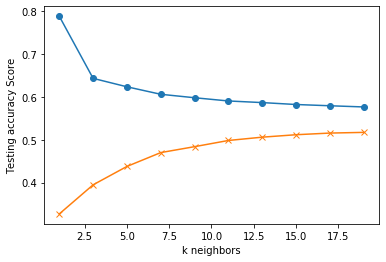

In [18]:
# Iterate through different k values to see which has the highest accuracy
train_scores = []
test_scores = []
for k in range(1, 20, 2):
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(tfidf_train, y_train)
    train_score = clf.score(tfidf_train, y_train)
    test_score = clf.score(tfidf_test, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    
plt.plot(range(1, 20, 2), train_scores, marker='o')
plt.plot(range(1, 20, 2), test_scores, marker="x")
plt.xlabel("k neighbors")
plt.ylabel("Testing accuracy Score")
plt.show()

##### K=15

In [20]:
# Create KNN classifer and fit it to training data
clf = KNeighborsClassifier(n_neighbors=15)
clf.fit(tfidf_train, y_train)

score = clf.score(tfidf_test, y_test)
print("KNN score:", score)

pred = clf.predict(tfidf_test)

print(confusion_matrix(y_test, pred))
print("Precision score: ",precision_score(y_test, pred, pos_label='positive', average='micro'))
print("Recall score:", recall_score(y_test, pred, pos_label='positive', average='micro'))

KNN score: 0.5115947925142392
[[  0   0   0 ...   0   0   0]
 [  0 719   0 ...   0   0   1]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   3   0 ...   0   0  65]]
Precision score:  0.5115947925142392
Recall score: 0.5115947925142392


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1298: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1298: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)
